In [1]:
!export HF_HOME=/run/media/anton/hdd/hf

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

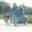

In [1]:
import os
import diffusers
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd.functional import jacobian

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

from diffusers import DDPMPipeline, UNet2DModel

from urllib.request import urlopen 
import json 




os.environ['HF_HOME'] = "/run/media/anton/hdd/hf"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model_id = "google/ddpm-cifar10-32"

ddpm = DDPMPipeline.from_pretrained(model_id) 
ddpm = ddpm.to(device)
image = ddpm().images[0]
image.save("ddpm_cifar10_generated.png")
image

In [2]:
random=False

if random:
    # create random unet
    unet_config_url = "https://huggingface.co/google/ddpm-cifar10-32/raw/main/config.json"
    response = urlopen(unet_config_url) 
    data_json = json.loads(response.read()) 
    unet_random = UNet2DModel(**data_json)
    
    # add to pipeline
    ddpm_random = DDPMPipeline(unet=unet_random, scheduler=ddpm.scheduler)
    ddpm = ddpm_random.to(device)

## Sample data

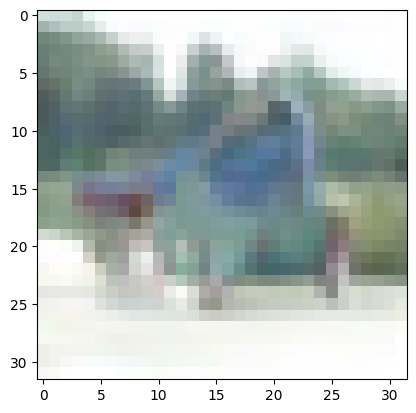

In [3]:
#cifar10 = load_dataset("uoft-cs/cifar10", split = "train", cache_dir="/run/media/anton/hdd/hf", streaming=True)
#training_data_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)
#image, y = next(iter(training_data_loader))

#image = image.to(device)

from torchvision.transforms import Compose, PILToTensor, ConvertImageDtype


def transform(image):
    transform = Compose([
        PILToTensor(),
        ConvertImageDtype(torch.float)
    ])
    return transform(image)

image = transform(image)

image = image[None, :]

# image = image[0]

plt.imshow(np.moveaxis(image[0].cpu().numpy(), 0, -1))

image = image.to(device)

plt.savefig("generated.jpg", dpi=300)

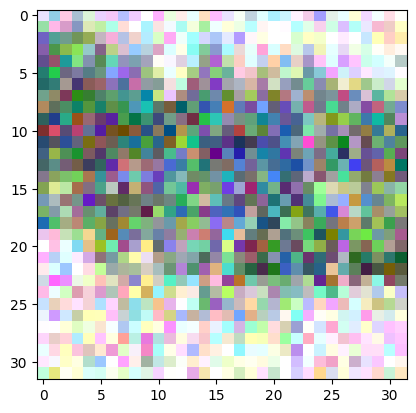

In [365]:
beta_start=1e-4
beta_end=2e-2
steps=1000
t=100

betas = torch.arange(start=beta_start, end=beta_end, step=(beta_end - beta_start)/steps)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, dim=0).to(device)

def add_noise(image, t, rescaled=False, return_beta=False):

    noise = torch.randn(image.shape).to(device)

    image_scaled = 2 * image - 1

    image_noisy = torch.sqrt(alphas_prod[t]) * image_scaled + torch.sqrt(1 - alphas_prod[t]) * noise

    if rescaled:
        image_noisy = torch.clip(image_noisy / 2 + 0.5, min=0, max=1)

    if return_beta:
        return image_noisy, betas[t]
    
    return image_noisy


image_noisy = add_noise(image=image, t=t, rescaled=True)

plt.imshow(np.moveaxis(image_noisy[0].cpu().numpy(), 0, -1))

plt.savefig(f"generated_noisy_{t}.jpg", dpi=300)

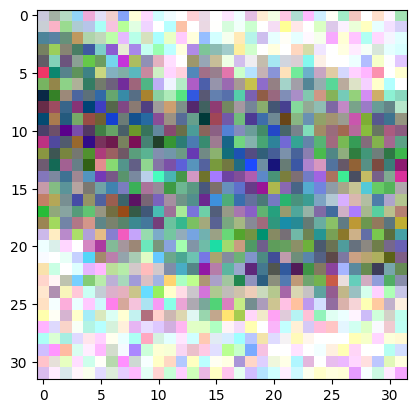

In [366]:
def denoise(image_noisy, t, rescaled=True):
    ## noisy image should be scaled [-1,1] 
    noise_pred = ddpm.unet(image_noisy, t).sample 
    #noise_pred = torch.clip(ddpm.unet(image_noisy, t).sample, -1, 1)

    mu_t = 1 / torch.sqrt(alphas[t]) * (image_noisy - (betas[t] / torch.sqrt(1 - alphas_prod[t])) * noise_pred)

    if rescaled: 
        return torch.clip(mu_t / 2 + 0.5, min=0, max=1)

    return mu_t

image_noisy = add_noise(image=image, t=t, rescaled=False)
image_denoised = denoise(image_noisy, t, rescaled=True)

plt.imshow(np.moveaxis(image_denoised[0].detach().cpu().numpy(), 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1228625..2.116956].


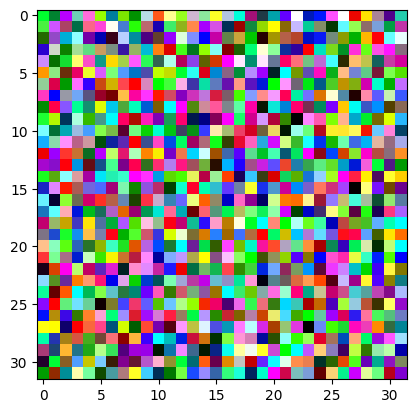

In [367]:
image_noisy = add_noise(image=image, t=t, rescaled=False)
noise_pred = ddpm.unet(image_noisy, t).sample / 2 + 0.5
plt.imshow(np.moveaxis(noise_pred[0].detach().cpu().numpy(), 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.044159353..1.4811777].


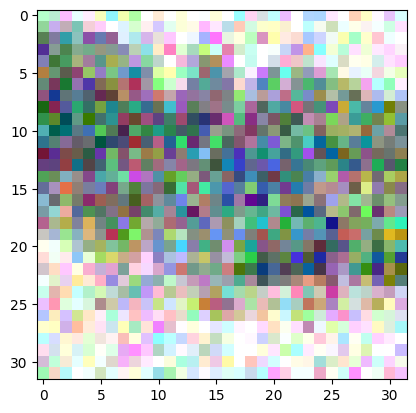

In [368]:
def noise_as_vector(x):
    x = torch.reshape(x, (1,3,32,32))
    out = ddpm.unet(x, t).sample
    return torch.reshape(out, (3072,))

def denoise_as_vector(x):
    x = torch.reshape(x, (1,3,32,32))
    pred = denoise(x, t, rescaled=False)
    return torch.reshape(pred, (3072,))

img_noisy_v = torch.reshape(image_noisy, (3072,)).to(device)

img_denoised_v = denoise_as_vector(img_noisy_v)

plt.imshow(np.moveaxis(torch.reshape(img_denoised_v / 2 + 0.5, (1,3,32,32))[0].detach().cpu().numpy(), 0, -1))

In [369]:
from torch.autograd.functional import jacobian

J_trained = jacobian(denoise_as_vector, inputs=img_noisy_v)

In [370]:
# eig = torch.linalg.eig(J_trained)
J_trained = jacobian(denoise_as_vector, inputs=img_noisy_v)
svd = torch.svd(J_trained)

In [371]:
# plt.plot(sorted(eig.eigenvalues.detach().cpu().numpy(), reverse=True))

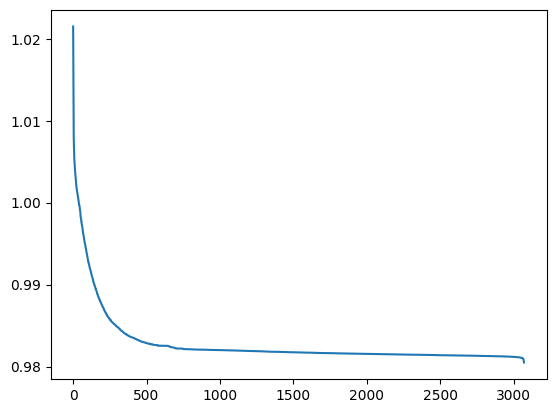

In [372]:
U = svd.U.detach().cpu().numpy()
S = svd.S.detach().cpu().numpy()
V = svd.V.detach().cpu().numpy()

plt.plot(S)

#U[0].shape

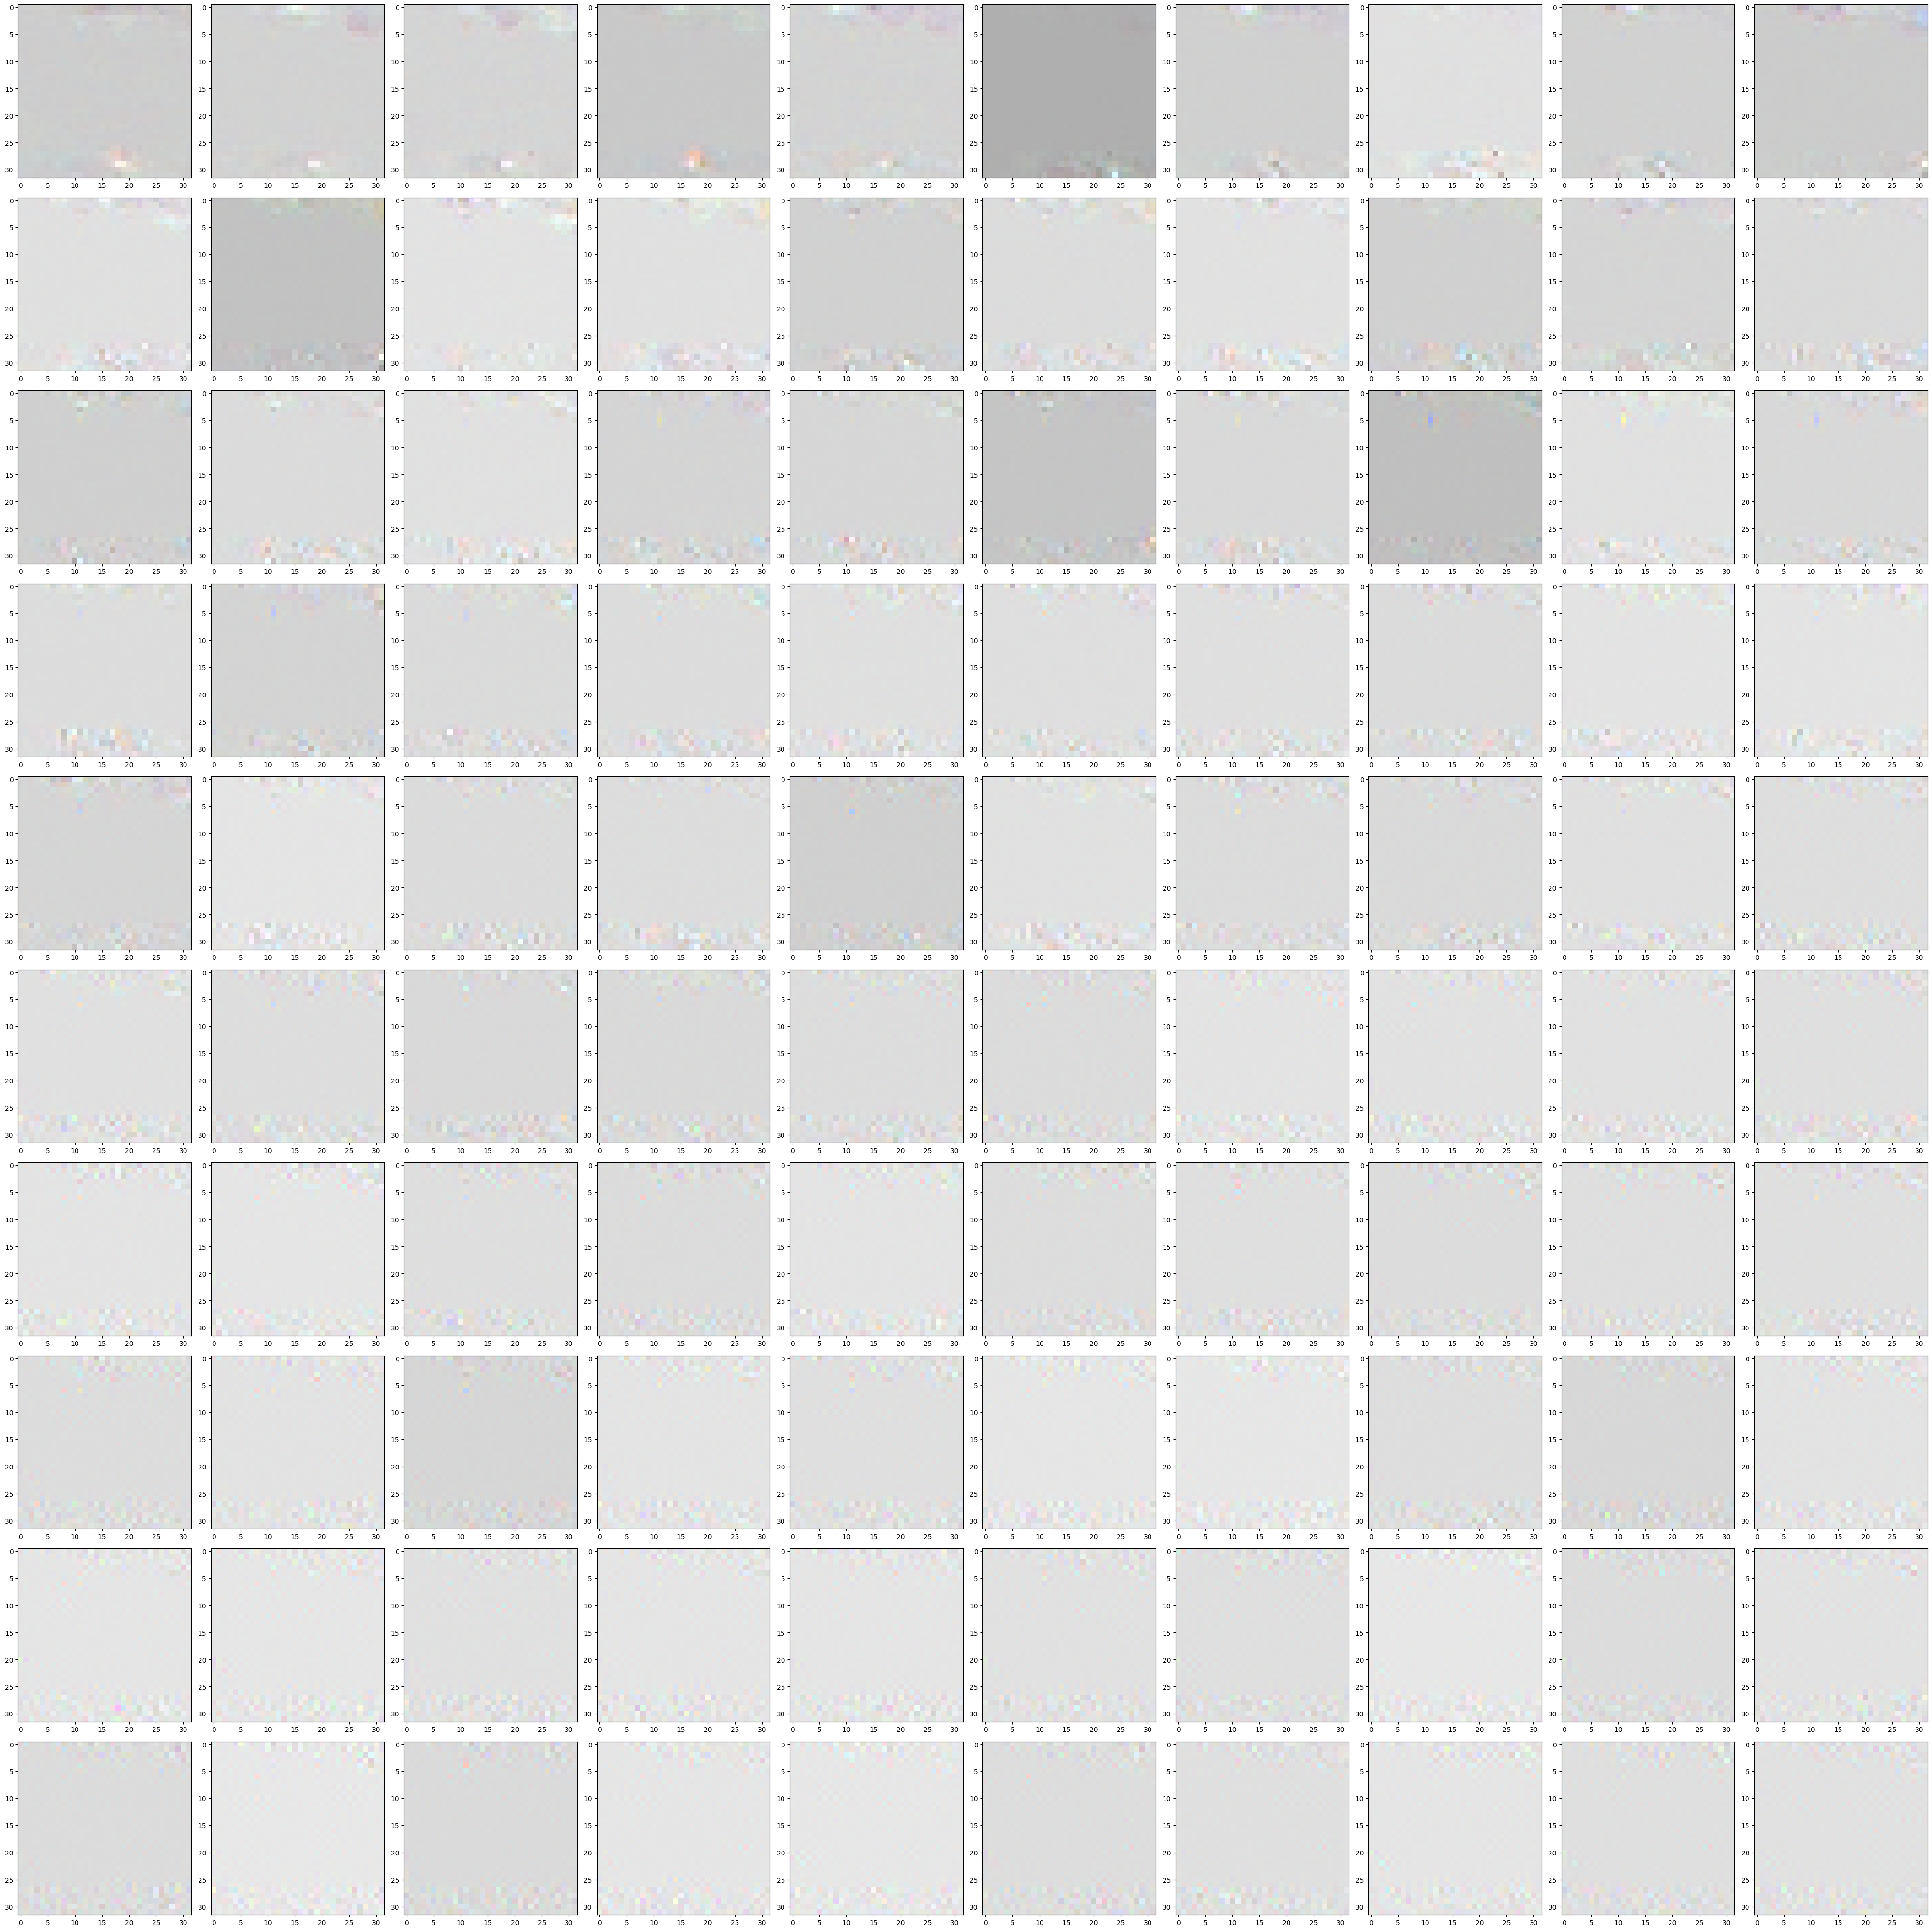

In [379]:
fig, axs = plt.subplots(10, 10, figsize=(40, 40))

axs = axs.flatten()

for j in range(100):
    top_sv = U[:, 3072-j-1]
    top_sv_tensor = torch.reshape(torch.tensor(top_sv), (3, 32, 32)) / 2 + 0.5
    top_sv_tensor /= torch.max(torch.abs(top_sv_tensor))
    axs[j].imshow(np.moveaxis(top_sv_tensor.numpy(), 0, -1))

plt.tight_layout()
plt.savefig(f"denoiser_top_sv_{t}.jpg",dpi=400)

In [374]:
torch.norm(J_trained - torch.diag(torch.diagonal(J_trained, 0)), p="fro")

tensor(0.1986, device='cuda:0')

In [375]:
torch.norm(svd.U @ svd.V.t(), p="fro")

tensor(55.4534, device='cuda:0')

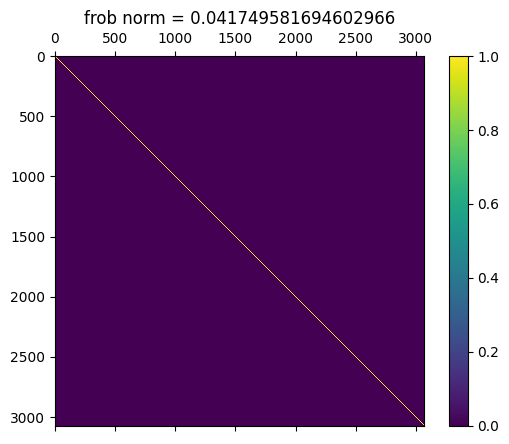

In [376]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(svd.U.cpu() @ svd.V.t().cpu(), interpolation='nearest')
fig.colorbar(cax)

ax.set_title("frob norm = " + str(torch.norm(svd.U @ svd.V.t() - torch.eye(3072).to(device), p="fro").item()))
plt.savefig(f"denoiser_diag_{t}.jpg",dpi=400)

In [377]:
torch.norm(svd.U @ svd.V.t() - torch.eye(3072).to(device), p="fro")

tensor(0.0417, device='cuda:0')

## Compute Discrete Laplacian

In [284]:
j = 5

In [285]:
top_sv = U[:, j]
top_sv = torch.reshape(torch.tensor(top_sv), (3, 32, 32)) / 2 + 0.5
top_sv_R = top_sv[2]

In [286]:
top_sv_R.shape

torch.Size([32, 32])

Text(0.5, 1.0, 'avg 0.5011091')

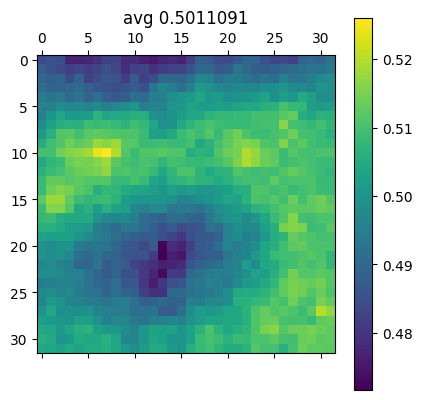

In [287]:
plt.matshow(top_sv_R)
plt.colorbar()

avg_intensity = torch.mean(top_sv_R)

plt.title(f"avg %.7f" % avg_intensity)

In [288]:
#discrete_laplace = torch.tensor(
#    [[-1, -1, -1],
#     [-1, 8, -1],
#     [-1, -1, -1]], dtype=torch.float32
#)

discrete_laplace = torch.tensor(
    [[0, -1, 0],
     [-1, 4, -1],
     [0, -1, 0]], dtype=torch.float32
)

discrete_laplace.shape

torch.Size([3, 3])

In [289]:
discrete_laplace[None, :].shape

torch.Size([1, 3, 3])

In [290]:
top_sv_R[None, :].shape

torch.Size([1, 32, 32])

In [291]:
from torch.nn.functional import conv2d

laplace_conv = conv2d(top_sv_R[None, :], discrete_laplace[None, None, :], stride=1)

Text(0.5, 1.0, 'avg 0.0001764')

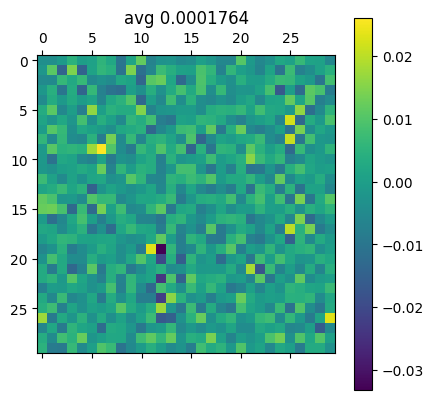

In [292]:
plt.matshow(laplace_conv[0])
plt.colorbar()

avg_lap_intensity = torch.mean(laplace_conv[0])

plt.title(f"avg %.7f" % avg_lap_intensity)

In [293]:
def harmonic_conv(image_channel, kernel=8, normalized=False):

    if len(image_channel.shape) == 2:
        image_channel = image_channel[None, :]
        #print(image_channel)
        
    if kernel not in [4, 8]:
        raise ValueError("kernel either 4 or 8")
    elif kernel==4:
        discrete_laplace = torch.tensor(
            [[0, -1, 0],
             [-1, 4, -1],
             [0, -1, 0]], dtype=torch.float32
        )
    elif kernel==8:
        discrete_laplace = torch.tensor(
            [[-1, -1, -1],
             [-1, 8, -1],
             [-1, -1, -1]], dtype=torch.float32
        )

    if normalized:
        discrete_laplace /= kernel

    discrete_laplace = discrete_laplace[None, None, :] 

    return torch.abs(conv2d(image_channel, discrete_laplace, stride=1))

def harmonicity(image):
    """
    return harmonicity for each channel
    """
    harm_conv = torch.vmap(harmonic_conv) 
    return torch.mean(harm_conv(image), dim=(-1, -2))

harmonicity(top_sv)

tensor([[0.0113],
        [0.0099],
        [0.0116]])

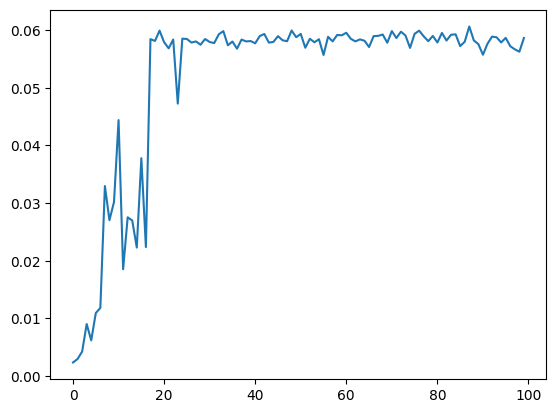

In [294]:
n_vec = 100

avg_harmonicity = []
channel_harmonicity = []


for j in range(n_vec):
    sv = U[:, j]
    sv = torch.reshape(torch.tensor(sv), (3, 32, 32)) / 2 + 0.5

    H = harmonicity(sv)

    channel_harmonicity.append(H)
    avg_harmonicity.append(torch.mean(H))


#torch.cat(avg_harmonicity, dim=0)

#plt.plot(torch.cat(avg_harmonicity, dim=0))
plt.plot(avg_harmonicity)

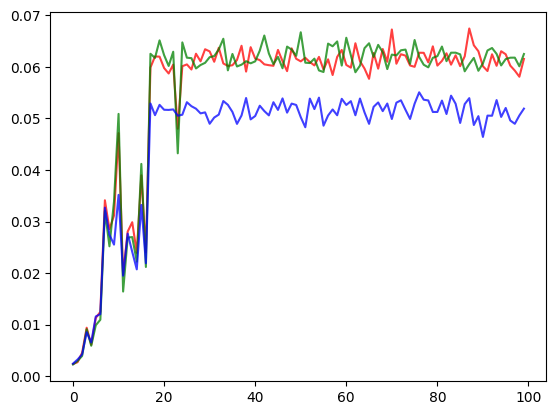

In [295]:
COLS = ["red", "green", "blue"]
for col, channel in zip(COLS, torch.cat(channel_harmonicity, dim=-1)):
    plt.plot(channel, color=col, alpha=0.75)

#plt.plot(torch.cat(channel_harmonicity, dim=-1).t())

# TODO: implement for all singular vectors

check the change in this with training and noise level
- for 10 noise levels
    - for a generated image
        - for each singular vector
              - check how harmonic it is

In [300]:
TIMES = [1] + list(range(0, 1000, 100))[1:] + [999]
TIMES

[1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]

In [310]:
N_VEC = 3072
TIMES = [1] + list(range(0, 1000, 100))[1:] + [999]

#TIMES = [1]

TOTAL_HARMONICITIES = {}


for T in TIMES:
    print(f"started {T}")
    image_noisy = add_noise(image=image, t=T, rescaled=True)

    img_noisy_v = torch.reshape(image_noisy, (3072,)).to(device)

    print("J")
    J_trained = jacobian(denoise_as_vector, inputs=img_noisy_v)

    print("svd")
    svd = torch.svd(J_trained)
    
    U = svd.U.detach().cpu().numpy()
    S = svd.S.detach().cpu().numpy()
    V = svd.V.detach().cpu().numpy()


    channel_harmonicity = []
    avg_harmonicity = []

    TOTAL_HARMONICITIES[T] = {}
    
    for j in range(N_VEC):
        # get rescaled singular vector
        
        sv = U[:, j]
        sv = torch.reshape(torch.tensor(sv), (3, 32, 32)) / 2 + 0.5

        # chekc
        H = harmonicity(sv)

        # save
        channel_harmonicity.append(H)
        avg_harmonicity.append(torch.mean(H))
        
    TOTAL_HARMONICITIES[T]["channel"] = channel_harmonicity
    TOTAL_HARMONICITIES[T]["avg"] = avg_harmonicity
    print("saved")

started 1
J
svd
saved
started 100
J
svd
saved
started 200
J
svd
saved
started 300
J
svd
saved
started 400
J
svd
saved
started 500
J
svd
saved
started 600
J
svd
saved
started 700
J
svd
saved
started 800
J
svd
saved
started 900
J
svd
saved
started 999
J
svd
saved


In [309]:
TOTAL_HARMONICITIES

{1: {'channel': [tensor([[0.0010],
           [0.0012],
           [0.0013]]),
   tensor([[0.0039],
           [0.0048],
           [0.0047]]),
   tensor([[0.0030],
           [0.0019],
           [0.0035]]),
   tensor([[0.0024],
           [0.0031],
           [0.0026]]),
   tensor([[0.0031],
           [0.0033],
           [0.0030]]),
   tensor([[0.0033],
           [0.0036],
           [0.0033]]),
   tensor([[0.0036],
           [0.0036],
           [0.0033]]),
   tensor([[0.0038],
           [0.0040],
           [0.0036]]),
   tensor([[0.0050],
           [0.0054],
           [0.0048]]),
   tensor([[0.0043],
           [0.0043],
           [0.0041]]),
   tensor([[0.0053],
           [0.0055],
           [0.0049]]),
   tensor([[0.0056],
           [0.0056],
           [0.0052]]),
   tensor([[0.0057],
           [0.0059],
           [0.0055]]),
   tensor([[0.0052],
           [0.0052],
           [0.0049]]),
   tensor([[0.0068],
           [0.0071],
           [0.0067]]),
   tensor([

In [324]:
cmap = mpl.colormaps['viridis']

In [326]:
list(cmap)

TypeError: 'ListedColormap' object is not iterable

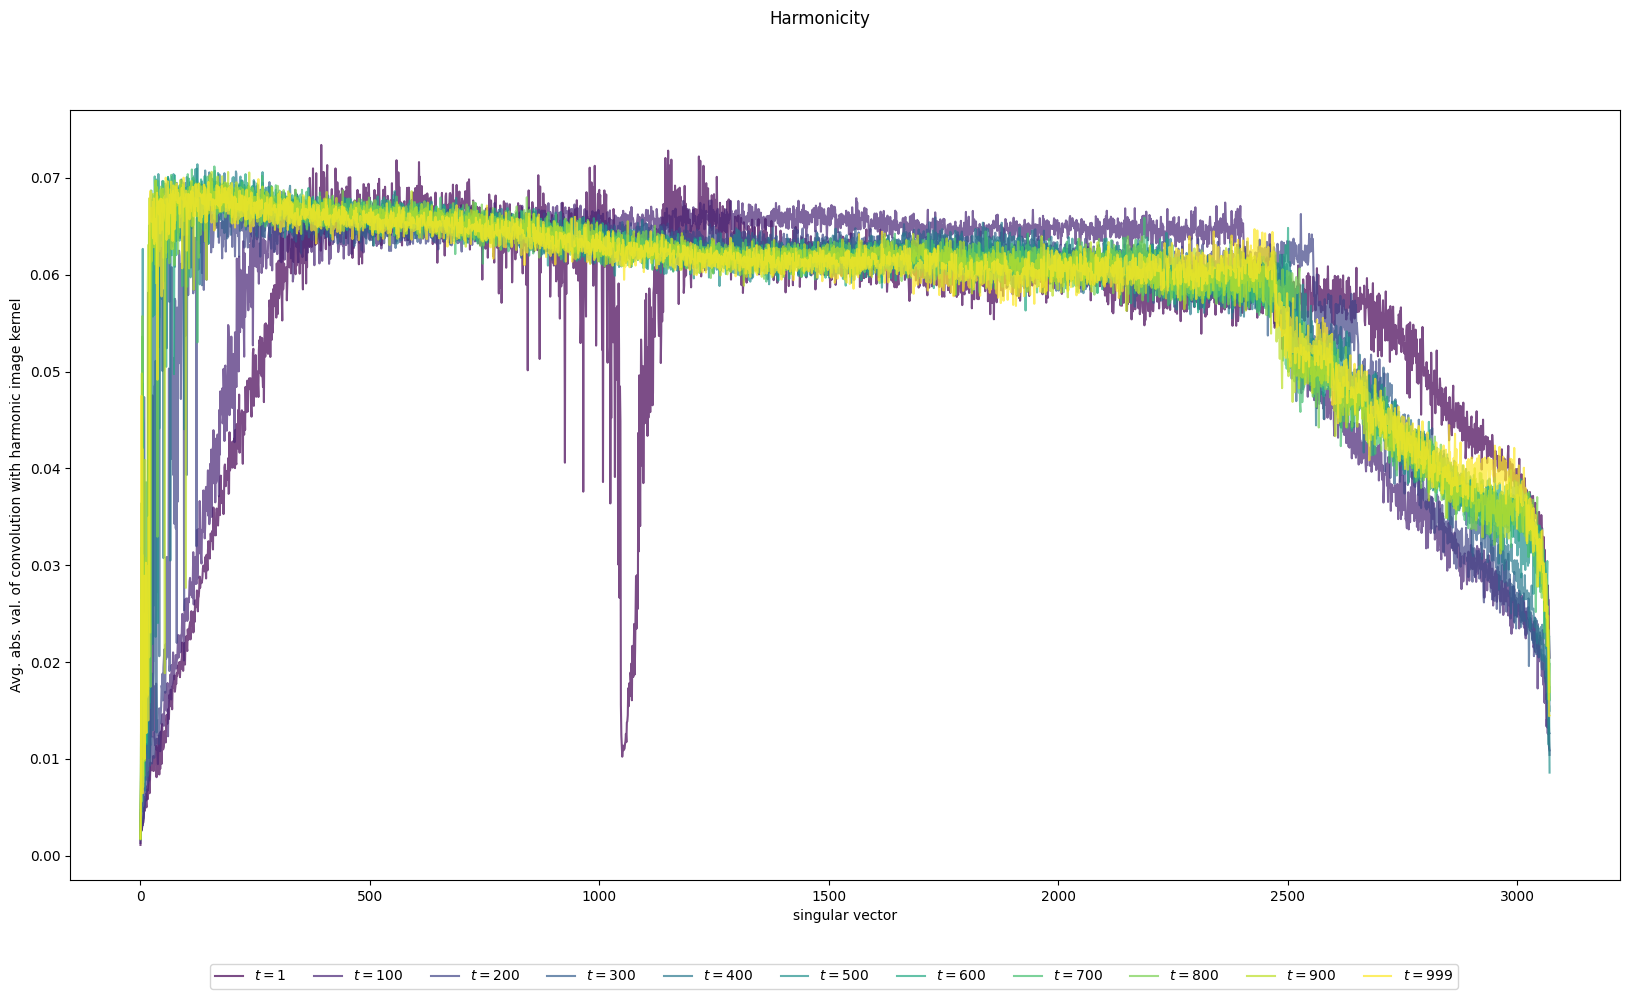

In [363]:
import matplotlib as mpl

cmap = plt.get_cmap('viridis', 11)  # 'viridis' is a popular colormap

fig, ax = plt.subplots(figsize=(20,10))

ax.set_prop_cycle('color', [cmap(i) for i in range(cmap.N)])

for T in TIMES:
    ax.plot(
        TOTAL_HARMONICITIES[T]["avg"], 
        label=f"$t = ${T}",
        alpha=0.7
    )

ax.legend(ncol = 11, bbox_to_anchor=(0.9, -0.1))

ax.set_xlabel("singular vector")
ax.set_ylabel("Avg. abs. val. of convolution with harmonic image kernel")


fig.suptitle("Harmonicity")
plt.savefig("jul29_allsv_harmonic.jpg", dpi=400)

In [307]:
TOTAL_HARMONICITIES

{}

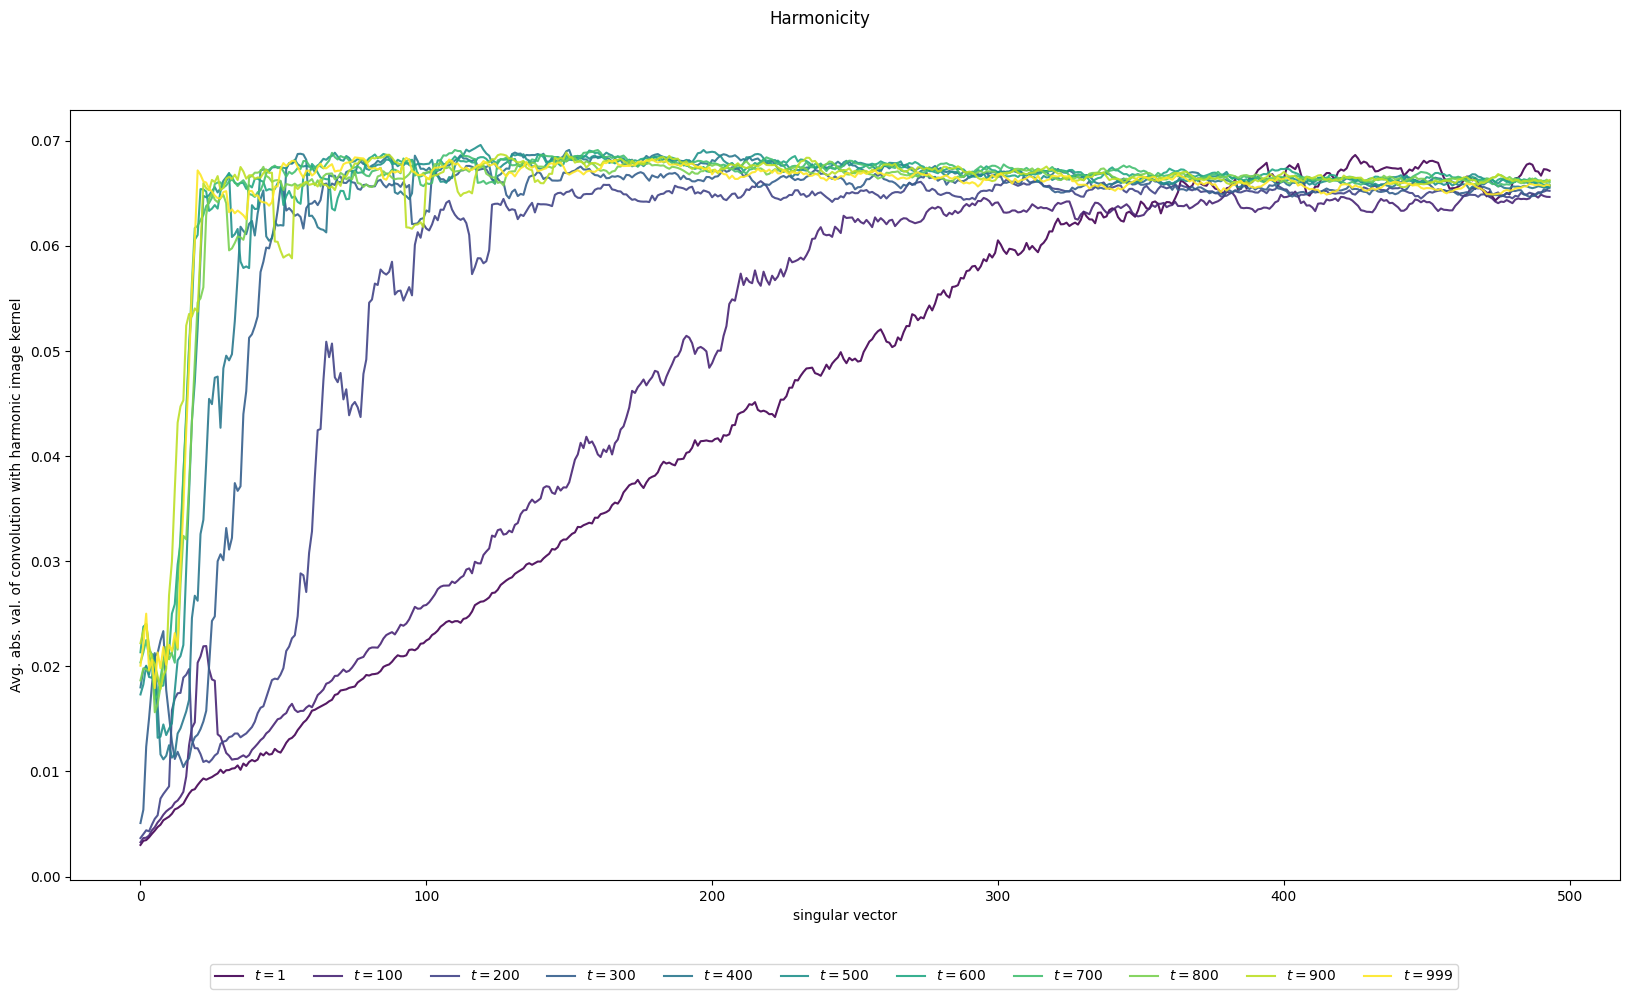

In [381]:
import matplotlib as mpl

cmap = plt.get_cmap('viridis', 11)  # 'viridis' is a popular colormap

fig, ax = plt.subplots(figsize=(20,10))

ax.set_prop_cycle('color', [cmap(i) for i in range(cmap.N)])

for T in TIMES:
    ax.plot(
        np.convolve(TOTAL_HARMONICITIES[T]["avg"][:500], np.ones(7)/7, mode='valid'),
        label=f"$t = ${T}",
        alpha=0.9,
    )
    
#ax.set_xscale('log')
ax.legend(ncol = 11, bbox_to_anchor=(0.9, -0.1))

ax.set_xlabel("singular vector")
ax.set_ylabel("Avg. abs. val. of convolution with harmonic image kernel")


fig.suptitle("Harmonicity")
plt.savefig("jul29_top500_harmonic.jpg", dpi=400)